In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
political_events = pd.read_csv('data/political_events.csv')
sp500 = pd.read_csv('data/sp500.csv')
sp500 = sp500.drop(columns='Unnamed: 0')
sp500.head()

,Date,Close,High,Low,Open,Volume
0,1990-01-02,359.690002,359.690002,351.980011,353.399994,162070000
1,1990-01-03,358.760010,360.589996,357.890015,359.690002,192330000
2,1990-01-04,355.670013,358.760010,352.890015,358.760010,177000000
3,1990-01-05,352.200012,355.670013,351.350006,355.670013,158530000
4,1990-01-08,353.790009,354.239990,350.540009,352.200012,140110000


In [13]:
sp500['Date'].max(), sp500['Date'].min()

('2024-12-31', '1990-01-03')

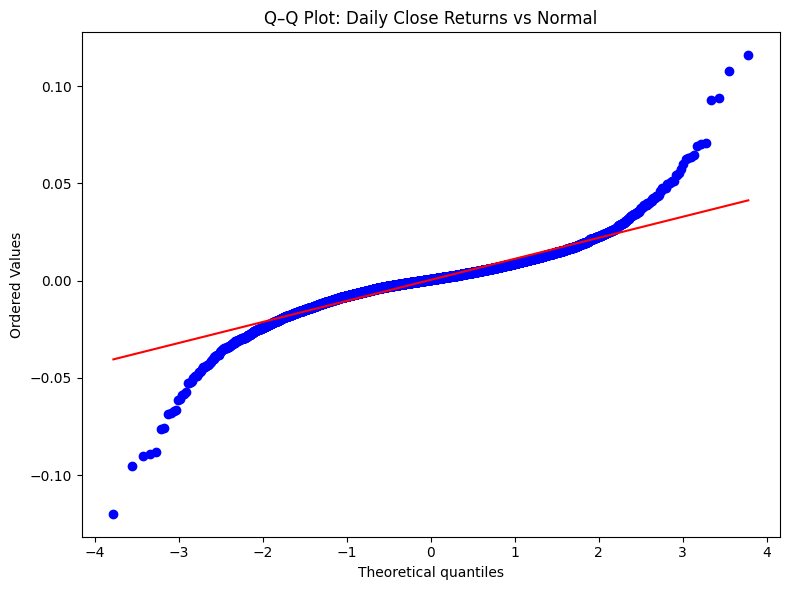

In [3]:
# 1) Q–Q plot of daily Close returns
sp500["close_return"] = sp500["Close"].pct_change()
returns = sp500["close_return"].dropna().astype(float)

plt.figure(figsize=(8, 6))
stats.probplot(returns, dist="norm", plot=plt)
plt.title("Q–Q Plot: Daily Close Returns vs Normal")
plt.tight_layout()
plt.savefig("qq_plot_close_returns.png", dpi=300, bbox_inches="tight")
plt.show()

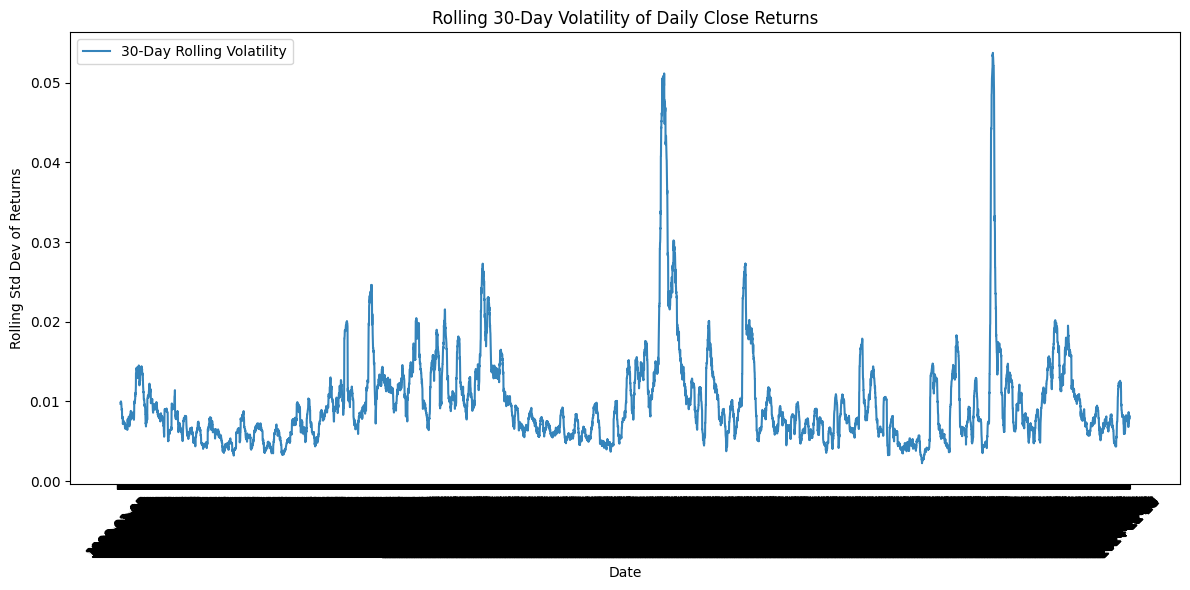

In [4]:
# 30-day rolling volatility of daily Close returns
rolling_vol = returns.rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(sp500.loc[returns.index, "Date"], rolling_vol, linewidth=1.5, label="30-Day Rolling Volatility", alpha=0.9)

plt.xlabel("Date")
plt.ylabel("Rolling Std Dev of Returns")
plt.title("Rolling 30-Day Volatility of Daily Close Returns")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Log prices and returns
sp500["log_close"] = np.log(sp500["Close"])
sp500["r"] = sp500["log_close"].diff()

# Squared returns (instantaneous volatility proxy)
sp500["r2"] = sp500["r"] ** 2

# Rolling volatility (used later as sigma_t)
SIGMA_WINDOW = 20
sp500["sigma_t"] = sp500["r"].rolling(SIGMA_WINDOW).std()

# Fill early NaNs conservatively
sp500["sigma_t"] = sp500["sigma_t"].fillna(
    sp500["r"].expanding(min_periods=5).std()
)

sp500 = sp500.dropna(subset=["r"]).reset_index(drop=True)

In [6]:
mu_hat = sp500["r"].mean()
sp500["eps"] = (sp500["r"] - mu_hat) / sp500["sigma_t"]

eps_pool = sp500["eps"].replace([np.inf, -np.inf], np.nan).dropna().values


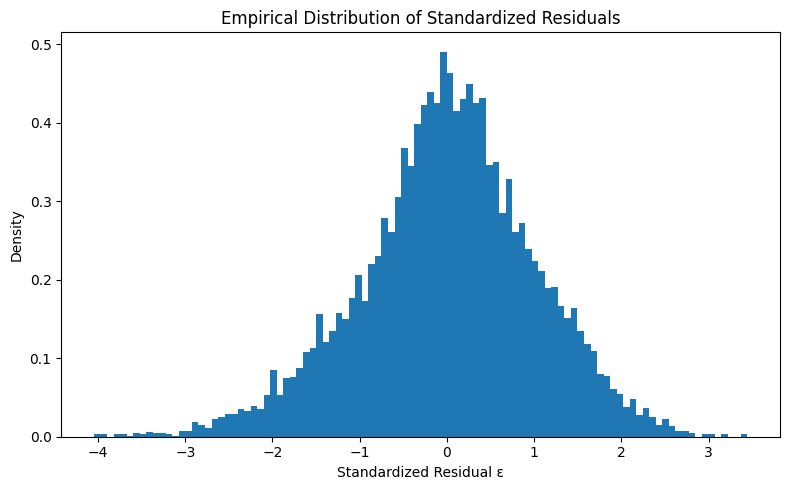

In [7]:
plt.figure(figsize=(8,5))
plt.hist(eps_pool, bins=100, density=True)
plt.xlabel("Standardized Residual ε")
plt.ylabel("Density")
plt.title("Empirical Distribution of Standardized Residuals")
plt.tight_layout()
plt.show()


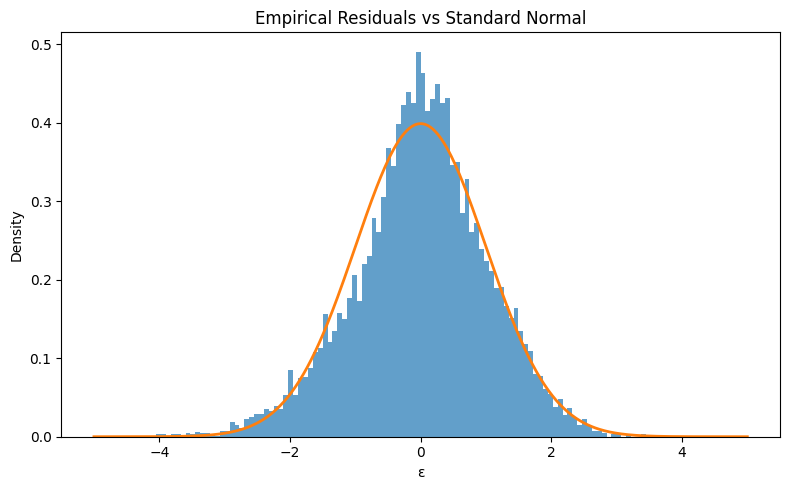

In [8]:
x = np.linspace(-5, 5, 500)

plt.figure(figsize=(8,5))
plt.hist(eps_pool, bins=100, density=True, alpha=0.7)
plt.plot(x, stats.norm.pdf(x), linewidth=2)
plt.xlabel("ε")
plt.ylabel("Density")
plt.title("Empirical Residuals vs Standard Normal")
plt.tight_layout()
plt.show()


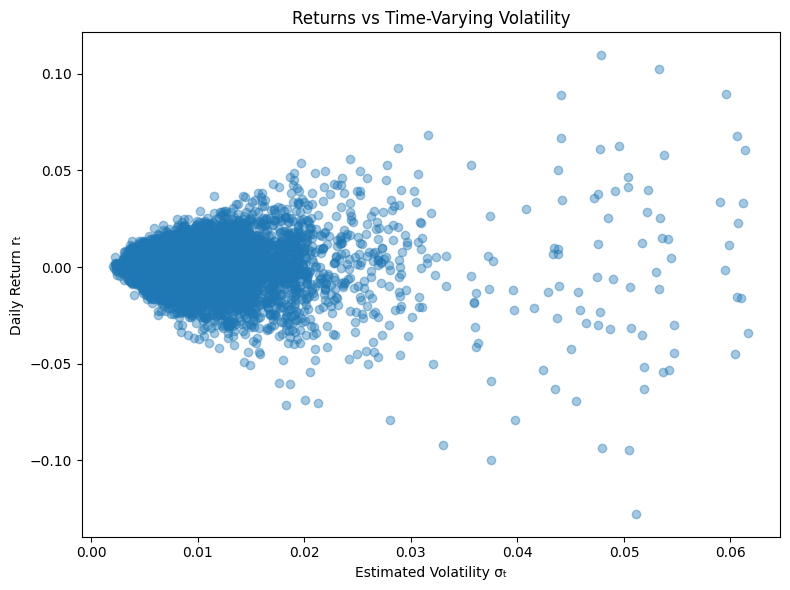

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(sp500["sigma_t"], sp500["r"], alpha=0.4)
plt.xlabel("Estimated Volatility σₜ")
plt.ylabel("Daily Return rₜ")
plt.title("Returns vs Time-Varying Volatility")
plt.tight_layout()
plt.show()


In [10]:
event_days = sp500.merge(
    political_events[["date"]], left_on="Date", right_on="date", how="inner"
)

non_event_days = sp500.merge(
    political_events[["date"]], left_on="Date", right_on="date", how="left", indicator=True
)
non_event_days = non_event_days[non_event_days["_merge"] == "left_only"]


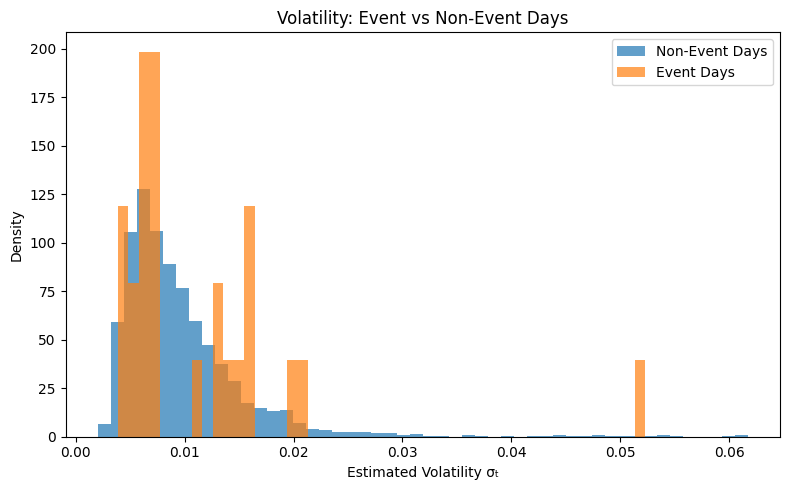

In [11]:
plt.figure(figsize=(8,5))
plt.hist(non_event_days["sigma_t"], bins=50, density=True, alpha=0.7, label="Non-Event Days")
plt.hist(event_days["sigma_t"], bins=50, density=True, alpha=0.7, label="Event Days")
plt.xlabel("Estimated Volatility σₜ")
plt.ylabel("Density")
plt.title("Volatility: Event vs Non-Event Days")
plt.legend()
plt.tight_layout()
plt.show()
